<a href="https://colab.research.google.com/github/ambideXtrous9/Histopathologic-Cancer-Detection/blob/main/Histopathological.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet opendatasets
!pip install --quiet torchmetrics
!pip install --quiet pytorch-lightning
!pip install --quiet kaggle

     |████████████████████████████████| 512 kB 6.7 MB/s 
     |████████████████████████████████| 800 kB 7.2 MB/s 
     |████████████████████████████████| 125 kB 93.5 MB/s 


In [2]:
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional.classification import multiclass_accuracy
import pytorch_lightning as pl

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [00:46<00:00, 208MB/s]
100% 6.31G/6.31G [00:46<00:00, 146MB/s]


In [7]:
!unzip -q /content/histopathologic-cancer-detection.zip

In [8]:
cancer_labels = pd.read_csv('/content/train_labels.csv')
cancer_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [9]:
cancer_labels.shape

(220025, 2)

In [10]:
np.random.seed(0)

In [11]:
train_imgs_orig = os.listdir('/content/train')

In [12]:
selected_image_list = []

for img in np.random.choice(train_imgs_orig,200000):
  selected_image_list.append(img)

In [13]:
len(selected_image_list)

200000

In [14]:
np.random.seed(0)
np.random.shuffle(selected_image_list)

In [15]:
cancer_train_idx = selected_image_list[:140000]
cancer_test_idx = selected_image_list[140000:]

In [16]:
len(cancer_train_idx)

140000

In [17]:
len(cancer_test_idx)

60000

In [19]:
os.mkdir('/content/histopathologic-cancer-detection/train_dataset/') 
for fname in cancer_train_idx:  
  src = os.path.join('/content/train', fname)  
  dst = os.path.join('/content/histopathologic-cancer-detection/train_dataset/', fname)  
  shutil.copyfile(src, dst)

In [20]:
os.mkdir('/content/histopathologic-cancer-detection/test_dataset/') 
for fname in cancer_test_idx:  
  src = os.path.join('/content/train', fname)  
  dst = os.path.join('/content/histopathologic-cancer-detection/test_dataset/', fname)  
  shutil.copyfile(src, dst)

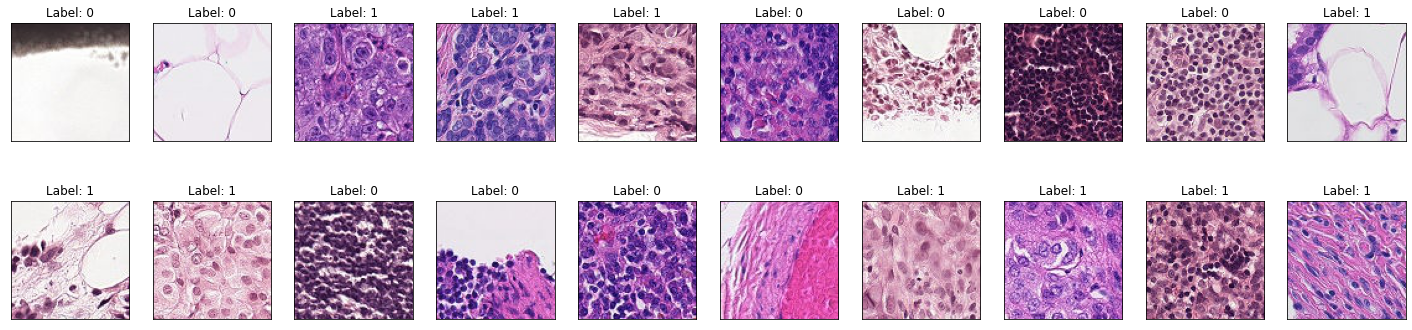

In [21]:
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("/content/train/" + img)
    plt.imshow(im)
    lab = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [22]:
selected_img_labels = pd.DataFrame()

In [23]:
id_list = []
label_list = []

In [25]:
for img in selected_image_list:
  label_tuple = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0]]
  id_list.append(label_tuple['id'].values[0])
  label_list.append(label_tuple['label'].values[0])

In [26]:
selected_img_labels['id'] = id_list
selected_img_labels['label'] = label_list
selected_img_labels.head()

,id,label
0,707a7d521408ec9eec3900393a69a4a5d223f365,1
1,8617ef92ba981b5f0b62aa11c7c9de973e03f45f,0
2,88ad79c2734d62eb8cc34bd2a84fd3147ece5a1a,1
3,3219cf13db6ba34fe00a28226f0588bc13f248d4,1
4,1372e3e37e916a6488b7d8e4055eb63ca40480a6,0


In [27]:
class LoadCancerDataset(Dataset):
  def __init__(self,data_folder,transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), dict_labels={}):
    self.data_folder = data_folder
    self.list_img_files = [s for s in os.listdir(data_folder)]
    self.transform = transform
    self.dict_labels = dict_labels
    self.labels = [dict_labels[i.split('.')[0]] for i in self.list_img_files]

  def __len__(self):
    return len(self.list_img_files)

  def __getitem__(self,idx):
    img_name = os.path.join(self.data_folder,  self.list_img_files[idx])
    image = Image.open(img_name)
    image = self.transform(image)
    image_name = self.list_img_files[idx].split('.')[0]
    label = self.dict_labels[image_name]
    return image,label

In [57]:
from torch.utils.data import random_split, DataLoader

class DataModuleClass(pl.LightningDataModule):
  def __init__(self,BS):
    super().__init__()
    self.train = '/content/histopathologic-cancer-detection/train_dataset/'
    self.val =   '/content/histopathologic-cancer-detection/test_dataset/'
    self.batch_size = BS
    self.data_T_train = T.Compose([T.CenterCrop(32),
                              T.RandomHorizontalFlip(),
                              T.RandomVerticalFlip(),
                              T.ToTensor()])

    self.data_T_test = T.Compose([T.CenterCrop(32),
                                  T.ToTensor()])
    
    self.img_label_dict = {k:v for k, v in zip(selected_img_labels.id, selected_img_labels.label)}  
  
  #def prepare_data(self):
      # Define steps that should be done on only one GPU, like getting data.
  
  def setup(self, stage=None):
      # Define steps that should be done on 
      # every GPU, like splitting data, applying transform etc.
      self.train_set = LoadCancerDataset(data_folder=self.train,
                              # datatype='train',                         
                              transform=self.data_T_train, dict_labels=self.img_label_dict)
      
      self.val_set = LoadCancerDataset(data_folder=self.val,
                              # datatype='train',                         
                              transform=self.data_T_test, dict_labels=self.img_label_dict)
  
  def train_dataloader(self):
      # Return DataLoader for Training Data here
      return DataLoader(self.train_set, self.batch_size, num_workers=2, pin_memory=True, shuffle=True,drop_last=True) 

  
  def val_dataloader(self):
      # Return DataLoader for Validation Data here
      return DataLoader(self.val_set, self.batch_size, num_workers=2, pin_memory=True,drop_last=True) 
  
  def test_dataloader(self):
      # Return DataLoader for Validation Data here
      return DataLoader(self.val_set, self.batch_size, num_workers=2, pin_memory=True,drop_last=True) 

In [58]:
class CNNImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):
        super().__init__()

        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters()

        self.model1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1),
                                    nn.BatchNorm2d(3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2),
                                    nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,stride=1,padding=1),
                                    nn.BatchNorm2d(6),
                                    nn.ReLU())
                                   
                                   
        self.model2 = nn.Sequential(nn.Linear(in_features=16 * 16 * 6,out_features=1024),
                                    nn.BatchNorm1d(1024),
                                    nn.Linear(in_features=1024,out_features=512),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(p=0.4),
                                    nn.Linear(in_features=512,out_features=256),
                                    nn.BatchNorm1d(256),
                                    nn.Linear(in_features=256,out_features=2),
                                    nn.Softmax())

      

    def forward(self, input):
        output = self.model1(input)
        output = output.view(-1, 6*16*16)
        output = self.model2(output)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs) 
        train_accuracy = multiclass_accuracy(outputs, targets,num_classes=2)
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', train_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss":loss, "train_accuracy":train_accuracy}

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs) 
        val_accuracy = multiclass_accuracy(outputs, targets,num_classes=2)
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', val_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"val_loss":loss, "val_acc": val_accuracy}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"]for x in outputs] #This part
        epoch_loss = torch.stack(batch_losses).mean() 
        batch_accs =  [x["val_acc"]for x in outputs]   #This part
        epoch_acc = torch.stack(batch_accs).mean()
        print(f"\nVal Accuracy : {epoch_acc.item():.4} "\
        f"Val Loss : {epoch_loss.item():.4}")   
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        test_accuracy = multiclass_accuracy(outputs, targets,num_classes=2)
        loss = self.loss(outputs, targets)
        self.log('test_accuracy', test_accuracy)
        return {"test_loss":loss, "test_accuracy":test_accuracy}

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

    # Calculate accuracy for each batch at a time
    def binary_accuracy(self, outputs, targets):
        _, outputs = torch.max(outputs,1)
        correct_results_sum = (outputs == targets).sum().float()
        acc = correct_results_sum/targets.shape[0]
        return acc

    def predict_step(self, batch, batch_idx):
        return self(batch)

In [60]:
data = DataModuleClass(BS=512)
model = CNNImageClassifier()
trainer = pl.Trainer(gpus=-1,
                        # progress_bar_refresh_rate=30,
                        # callbacks=[ckpt_callback],
                        log_every_n_steps=25,
                        max_epochs=10)
trainer.fit(model,data)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type             | Params
--------------------------------------------
0 | loss   | CrossEntropyLoss | 0     
1 | model1 | Sequential       | 270   
2 | model2 | Sequential       | 2.2 M 
--------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.938     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Val Accuracy : 0.5 Val Loss : 0.6921


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Val Accuracy : 0.7697 Val Loss : 0.5227


Validation: 0it [00:00, ?it/s]


Val Accuracy : 0.7523 Val Loss : 0.5277


Validation: 0it [00:00, ?it/s]


Val Accuracy : 0.7887 Val Loss : 0.504


Validation: 0it [00:00, ?it/s]


Val Accuracy : 0.6931 Val Loss : 0.5671


Validation: 0it [00:00, ?it/s]


Val Accuracy : 0.7806 Val Loss : 0.5098


Validation: 0it [00:00, ?it/s]


Val Accuracy : 0.7927 Val Loss : 0.508


Validation: 0it [00:00, ?it/s]


Val Accuracy : 0.7846 Val Loss : 0.502


Validation: 0it [00:00, ?it/s]


Val Accuracy : 0.7884 Val Loss : 0.4998


Validation: 0it [00:00, ?it/s]


Val Accuracy : 0.7565 Val Loss : 0.5123


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Val Accuracy : 0.7849 Val Loss : 0.4981


In [56]:
data.train_set

In [52]:
a

In [61]:
trainer.validate(model=model, dataloaders=data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]


Val Accuracy : 0.7849 Val Loss : 0.4981
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     train_accuracy         0.7848643064498901
       train_loss           0.49805739521980286
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'train_accuracy': 0.7848643064498901, 'train_loss': 0.49805739521980286}]